In [1]:
import os
import pickle
from itertools import product
import logging
import copy
import random

import librosa
import numpy as np
from torch.utils.data import Dataset
import networkx as nx
from tqdm import tqdm
from scipy.io import wavfile
from scipy.signal import fftconvolve
from skimage.measure import block_reduce
from ss_baselines.common.utils import to_tensor
from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING

import os
import torch
import numpy as np
from soundspaces.utils import load_metadata
from ss_baselines.savi.pretraining_ours.audiogoal_predictor import AudioGoalPredictor
from ss_baselines.savi.pretraining_ours.audiogoal_dataset import AudioGoalDataset
from ss_baselines.savi.config.default import get_config
from soundspaces.mp3d_utils import SCENE_SPLITS


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
2026-01-26 17:19:04.463499: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-26 17:19:04.519567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-26 17:19:05.30

In [2]:

# -----------------------
# 1) 基本配置（你按需改）
# -----------------------
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CONFIG_PATH = "/home/Disk/sound-space/ss_baselines/savi/config/semantic_audionav/savi.yaml"
SPLIT = "val"                 # "train" / "val" / "test"
USE_CACHE = False             # 建议 inference 时 False，避免占用巨大内存
           # 你要看的 dataset index
PREDICT_LABEL = False
PREDICT_LOCATION = True

# 可选：加载 ckpt（设为 None 就不加载）
CKPT_PATH = "/home/Disk/yyz/sound-spaces/data/models/savi_final_depth_ipd/ckpt.46.pth"   # or None


# -----------------------
# 2) 构建 config / dataset
# -----------------------
config = get_config(config_paths=CONFIG_PATH, opts=None, run_type=None)
meta_dir = config.TASK_CONFIG.SIMULATOR.AUDIO.METADATA_DIR

scenes = SCENE_SPLITS[SPLIT]

scene_graphs = {}
for scene in scenes:
    points, graph = load_metadata(os.path.join(meta_dir, "mp3d", scene))
    scene_graphs[scene] = graph

dataset = AudioGoalDataset(
    scene_graphs=scene_graphs,
    scenes=scenes,
    split=SPLIT,
    use_polar_coordinates=True,
    use_cache=USE_CACHE,
)

print(f"[INFO] dataset split={SPLIT}, len={len(dataset)}")


# -----------------------
# 3) 构建模型 + 可选加载权重
# -----------------------
model = AudioGoalPredictor(
    predict_label=PREDICT_LABEL,
    predict_location=PREDICT_LOCATION
).to(DEVICE)
model.eval()

if CKPT_PATH is not None and os.path.exists(CKPT_PATH):
    ckpt = torch.load(CKPT_PATH, map_location="cpu")
    # 你的 trainer 存的是 {"audiogoal_predictor": state_dict}
    if "audiogoal_predictor" in ckpt:
        model.load_state_dict(ckpt["audiogoal_predictor"], strict=True)
        print(f"[INFO] loaded ckpt: {CKPT_PATH}")
    else:
        # 万一你保存的是裸 state_dict
        model.load_state_dict(ckpt, strict=True)
        print(f"[INFO] loaded ckpt (raw state_dict): {CKPT_PATH}")
else:
    print("[WARN] ckpt not loaded (path is None or not exists).")




[AudioGoalDataset] Load cache: /home/Disk/yyz/sound-spaces/cache/mp3d_val_pairs25000_polar1.npz
[INFO] dataset split=val, len=42452
[INFO] loaded ckpt: /home/Disk/yyz/sound-spaces/data/models/savi_final_depth_ipd/ckpt.46.pth


In [3]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# def goals_to_numpy(goals):
#     # goals: list[Tensor(3,)] or list[np.array]
#     if len(goals) == 0:
#         return np.zeros((0, 3), dtype=np.float32)
#     if torch.is_tensor(goals[0]):
#         g = torch.stack(goals, dim=0).cpu().numpy()  # (N,3)
#     else:
#         g = np.asarray(goals, dtype=np.float32)
#     return g

# def stats_from_dataset_goals(dataset, dist_min=1.0, dist_max=15.0, num_bins=14, plot=True):
#     g = goals_to_numpy(dataset.goals)   # (N,3) -> [label, x, y]
#     labels = g[:, 0].astype(np.int64)
#     xs = g[:, 1]
#     ys = g[:, 2]
#     dists = np.sqrt(xs*xs + ys*ys)

#     print(f"N goals: {len(dists)}")
#     if len(dists) > 0:
#         print(f"dist min/max/mean/std: {dists.min():.3f} / {dists.max():.3f} / {dists.mean():.3f} / {dists.std():.3f}")

#     # 分桶统计
#     edges = np.linspace(dist_min, dist_max, num_bins + 1)
#     counts, _ = np.histogram(dists, bins=edges)

#     total = counts.sum()
#     print("\nBin stats:")
#     for i in range(num_bins):
#         lo, hi = edges[i], edges[i+1]
#         ratio = counts[i] / total if total > 0 else 0
#         print(f"[{lo:4.1f}, {hi:4.1f}) m : {counts[i]:6d}  ({ratio*100:5.2f}%)")
#     if total > 0:
#         print("\nMax/Min bin count ratio:", counts.max() / max(counts.min(), 1))

#     # label 分布（可选）
#     uniq, cnt = np.unique(labels, return_counts=True)
#     print("\nLabel distribution (top 20):")
#     order = np.argsort(-cnt)
#     for u, c in list(zip(uniq[order], cnt[order]))[:20]:
#         print(f"label {u:3d}: {c}")

#     if plot and len(dists) > 0:
#         plt.figure(figsize=(8,4))
#         plt.hist(dists, bins=edges, edgecolor="black")
#         plt.xlabel("GT distance (m)")
#         plt.ylabel("Count")
#         plt.title(f"GT distance distribution [{dist_min},{dist_max}] m")
#         plt.grid(True, axis="y", linestyle="--", alpha=0.5)
#         plt.show()

#         # (x,y) scatter 看方向覆盖
#         plt.figure(figsize=(5,5))
#         plt.scatter(xs, ys, s=1, alpha=0.25)
#         plt.xlabel("x (m)")
#         plt.ylabel("y (m)")
#         plt.axis("equal")
#         plt.title("GT (x,y) distribution")
#         plt.grid(True, linestyle="--", alpha=0.3)
#         plt.show()

#     return dists, counts, edges

# # 用法
# dists, counts, edges = stats_from_dataset_goals(dataset, dist_min=1.0, dist_max=15.0, num_bins=14, plot=True)


========== SAMPLE ==========
Index: 314

========== GT ==========
GT doa label: 315
pred doa   : tensor(315)
GT dis label: 6
pred dis   : tensor(6)


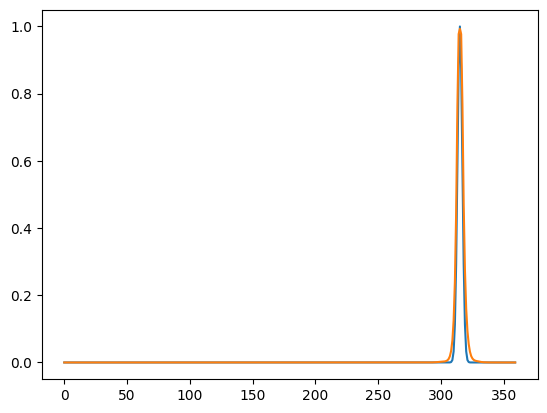

In [4]:
import matplotlib.pyplot as plt
# -----------------------
# 4) 取一个 sample，跑一次 forward
# -----------------------
# for SAMPLE_INDEX in range(100,200):
SAMPLE_INDEX = 314
(inputs_list, gt) = dataset[SAMPLE_INDEX]      # inputs_list = [spectrogram], gt shape (3,)
spectrogram = inputs_list[0]                  # torch tensor, shape (2, 65, 26)
depth       = inputs_list[1]                  # torch tensor, shape (1, 128, 128)
gt_doa, gt_dis = gt
# 加 batch 维度 -> (1, 2, 65, 26)
spec = spectrogram.unsqueeze(0).to(DEVICE, dtype=torch.float32)
depth = depth.unsqueeze(0).to(DEVICE, dtype=torch.float32)

with torch.no_grad():
    pred_doa,pred_dis = model({"spectrogram": spec, "depth":depth})          # shape: (1, C) or (1, C+2) or (1,2)
    pred_doa = pred_doa.squeeze(0).cpu()
    pred_dis = pred_dis.squeeze(0).cpu()
    
gt_doa_np = gt_doa.cpu().numpy() if torch.is_tensor(gt_doa) else np.array(gt_doa)
gt_dis_np = gt_dis.cpu().numpy() if torch.is_tensor(gt_dis) else np.array(gt_dis)    
print("========== SAMPLE ==========")
print("Index:", SAMPLE_INDEX)
print("\n========== GT ==========")
# gt[0] 是 label index；gt[1:] 是 (x,y)
print("GT doa label:", int(np.argmax(gt_doa_np)))
print("pred doa   :", np.argmax(pred_doa))
print("GT dis label:", int(np.argmax(gt_dis)))
print("pred dis   :", np.argmax(pred_dis))
plt.plot(gt_doa_np)
plt.plot(pred_doa)

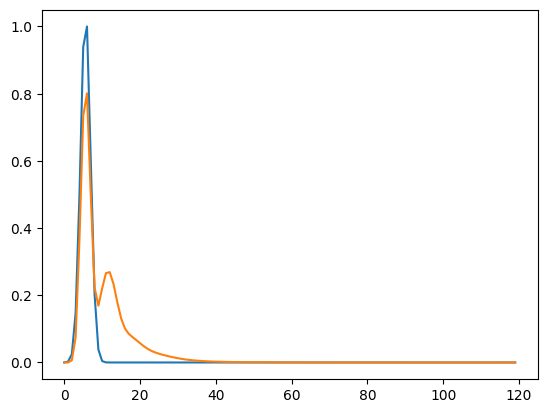

In [5]:
plt.plot(gt_dis_np)
plt.plot(pred_dis)

Pred DOA cls: 291 Pred DIS cls: 75 gt_doa 109


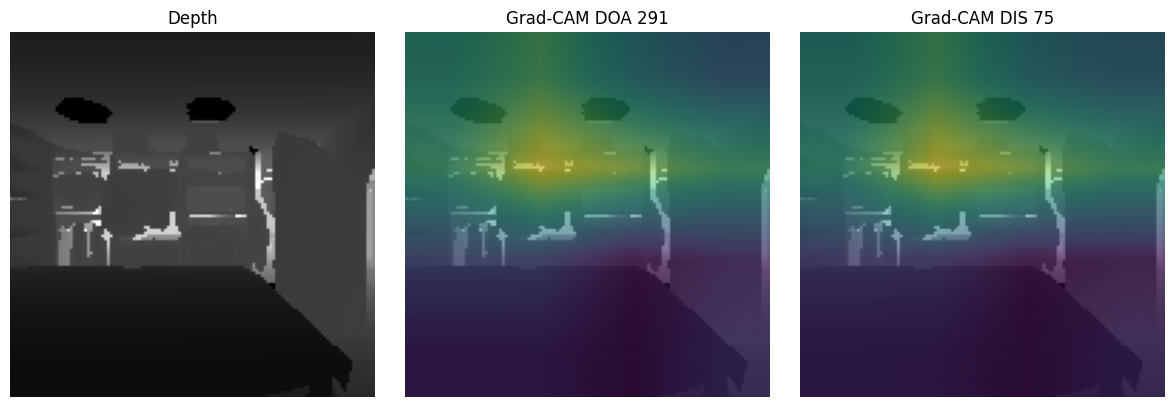

In [24]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model: torch.nn.Module, target_layer: torch.nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        def fwd_hook(module, inp, out):
            self.activations = out
            # 关键：让 activation 保留梯度（即使不是 leaf）
            if isinstance(out, torch.Tensor):
                out.retain_grad()

        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.h1 = self.target_layer.register_forward_hook(fwd_hook)
        self.h2 = self.target_layer.register_full_backward_hook(bwd_hook)

    def remove(self):
        self.h1.remove()
        self.h2.remove()

    @staticmethod
    def normalize(cam: torch.Tensor) -> torch.Tensor:
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam

    def cam(self, inputs: dict, branch="doa", class_idx=None, upsample_size=(128,128)):
        self.model.eval()
        self.model.zero_grad(set_to_none=True)

        pred_doa, pred_dis = self.model(inputs)
        logits = pred_doa if branch == "doa" else pred_dis

        if class_idx is None:
            class_idx = int(torch.argmax(logits, dim=1).item())

        score = logits[:, class_idx].sum()

        self.model.zero_grad(set_to_none=True)
        score.backward(retain_graph=True)

        A = self.activations
        dA = self.gradients

        # 关键诊断：把缺哪一步打印出来
        if A is None:
            raise RuntimeError("No activations captured. target_layer 没有走到（可能选错层）")
        if dA is None:
            raise RuntimeError("No gradients captured. depth 分支可能没建计算图（看下面的 depth.requires_grad 处理）")

        w = dA.mean(dim=(2,3), keepdim=True)
        cam = F.relu((w * A).sum(dim=1, keepdim=True))
        cam = F.interpolate(cam, size=upsample_size, mode="bilinear", align_corners=False)
        cam = self.normalize(cam)[0,0].detach().cpu().numpy()
        return cam, pred_doa.detach(), pred_dis.detach(), class_idx


SAMPLE_INDEX = 766
(inputs_list, gt) = dataset[SAMPLE_INDEX]      # inputs_list = [spectrogram], gt shape (3,)
spectrogram = inputs_list[0]                  # torch tensor, shape (2, 65, 26)
depth       = inputs_list[1]                  # torch tensor, shape (1, 128, 128)
gt_doa, gt_dis = gt
# 加 batch 维度 -> (1, 2, 65, 26)
spec = spectrogram.unsqueeze(0).to(DEVICE, dtype=torch.float32)
depth = depth.unsqueeze(0).to(DEVICE, dtype=torch.float32)


# ----------------------------
# 1) 选 depth_encoder 的 target layer（你这个结构最推荐这层）
# ----------------------------
target_layer = model.depth_encoder.features[7][1].conv2  

cam_extractor = GradCAM(model, target_layer)

# ----------------------------
# 2) 关键：不要用 torch.no_grad()
#    关键：让 depth 输入 requires_grad=True，确保 depth 分支建图
# ----------------------------
spec_cam  = spec  # spec 已经在 DEVICE 上
depth_cam = depth.clone().detach().requires_grad_(True)  # <= 关键

inputs = {"spectrogram": spec_cam, "depth": depth_cam}

cam_doa, pred_doa_t, pred_dis_t, doa_cls = cam_extractor.cam(
    inputs, branch="doa", class_idx=None, upsample_size=(depth.shape[-2], depth.shape[-1])
)

cam_dis, _, _, dis_cls = cam_extractor.cam(
    inputs, branch="dis", class_idx=None, upsample_size=(depth.shape[-2], depth.shape[-1])
)

print("Pred DOA cls:", doa_cls, "Pred DIS cls:", dis_cls,"gt_doa",int(np.argmax(gt_doa)))

# ----------------------------
# 3) 可视化
# ----------------------------
depth_np = depth_cam[0,0].detach().cpu().numpy()
depth_vis = (depth_np - depth_np.min()) / (depth_np.max() - depth_np.min() + 1e-8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Depth"); plt.imshow(depth_vis, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"Grad-CAM DOA {doa_cls}"); plt.imshow(depth_vis, cmap="gray"); plt.imshow(cam_doa, alpha=0.5); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Grad-CAM DIS {dis_cls}"); plt.imshow(depth_vis, cmap="gray"); plt.imshow(cam_dis, alpha=0.5); plt.axis("off")
plt.tight_layout(); plt.show()

cam_extractor.remove()
